In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba) 
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/urochloa_fusca"

# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])



#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
input <- here(working_dir,"urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
meta <- here(working_dir,"uf.leaf_annotation.V1.meta.txt")
gene <- here(working_dir,"Uf.combined_known_de_novo_markers.visualize.txt")
gene_DA <- here(working_dir,"Ufusca_669_v1.1.gene_only.bed")
#prefix <- "TEST_SORGHUM_TEST"

meta_data <- read.delim(meta)
gene_markers <- read_delim(gene)

gene_markers <- gene_markers  %>%
    arrange(type)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0.9000     v readr     2.1.4     
v ggplot2   3.4.1          v stringr   1.5.0     
v lubridate 1.9.2          v tibble    3.2.1     
v purrr     1.0.1          v tidyr     1.3.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() m

In [2]:
unique(meta_data$cell_type)
`%ni%` <- Negate(`%in%`)

meta_data  <- meta_data %>%
  mutate(final_annotation = annotation_v1) %>% 
  mutate(cell_type = case_when(final_annotation == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                               final_annotation == "companion_cells" ~ "companion_cells/sieve_elements",
                               final_annotation == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                               final_annotation == "mesophyll;developing" ~ "mesophyll developing",
                               TRUE ~ final_annotation)) %>% 
  dplyr::filter(is.na(cell_type) != TRUE)  %>%  
  mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
  mutate_at(vars(cell_type), 
            list(factor)) %>% 
  dplyr::filter(cell_type != "unknown;1")

meta_data  %>% 
    group_by(cell_type)  %>% 
    summarise(counts = n())


NULL

cell_type,counts
<fct>,<int>
bundle sheath,7219
companion cells/sieve elements,1193
epidermis,5440
mesophyll,5257


In [3]:
all_markers <- gene_markers$geneID

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

head(merged_meta_cpm_information_copied)

head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -cell_type, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    mutate(Zscore = as.numeric(Zscore))%>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(cell_type)  %>% 
    mutate(Zscore_group = scale(Zscore))

Rows: 73649352 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "cellID"               "total"                "tss"                 
 [4] "acrs"                 "ptmt"                 "nSites"              
 [7] "log10nSites"          "pTSS"                 "FRiP"                
[10] "pOrg"                 "tss_z"                "acr_z"               
[13] "sites_z"              "qc_check"             "background"          
[16] "cellbulk"             "is_cell"              "sampleID"            
[19] "umap1"                "umap2"                "doubletscore"        
[22] "d.type"               "LouvainClusters"      "Louvain_cluster_safe"
[25] "annotation_v1"        "subcluster_lc_safe"   "umap1.subcluster"    
[28] "umap2.subcluster"     "counts"               "annotation_v1_ncell" 
[31] "final_annotation"     "cell_type"

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


cell_type,geneID,counts,grouped_CPM
<fct>,<chr>,<dbl>,<dbl>
bundle sheath,Urofu.1G000100.v1.1,412,5.1511363
bundle sheath,Urofu.1G000200.v1.1,8550,106.8985818
bundle sheath,Urofu.1G000300.v1.1,8393,104.9356488
bundle sheath,Urofu.1G000400.v1.1,1385,17.3163200
bundle sheath,Urofu.1G000500.v1.1,892,11.1524602
bundle sheath,Urofu.1G000600.v1.1,74,0.9252041


cell_type,geneID,counts,grouped_CPM
<fct>,<chr>,<dbl>,<dbl>
bundle sheath,Urofu.1G000100.v1.1,412,5.1511363
bundle sheath,Urofu.1G000200.v1.1,8550,106.8985818
bundle sheath,Urofu.1G000300.v1.1,8393,104.9356488
bundle sheath,Urofu.1G000400.v1.1,1385,17.3163200
bundle sheath,Urofu.1G000500.v1.1,892,11.1524602
bundle sheath,Urofu.1G000600.v1.1,74,0.9252041


In [4]:
# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, cell_type, accessability, geneID) 

dim(merged_meta_cellID_values_all_genes)

dim(unique(merged_meta_cellID_values_all_genes))

merged_meta_cellID_values_all_genes  %>% 
    group_by(cellID, cell_type, accessability, geneID)  %>% 
    summarise(counts=n())  %>% 
    dplyr::filter(counts > 1)

colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-cell_type, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(cell_type, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))

[1] 49456543        4

[1] 49456543        4

`summarise()` has grouped output by 'cellID', 'cell_type', 'accessability'. You
can override using the `.groups` argument.


cellID,cell_type,accessability,geneID,counts
<chr>,<fct>,<dbl>,<chr>,<int>


[1] "cellID"        "cell_type"     "accessability" "geneID"

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [5]:
### 7/23/2022 List of maarkers
good_marker_list <- c("sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1", 
                      "sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2", "ba2", 
                      "acl1", "bhlh43", "ssu2_ortho_count_1__ssu1_ortho_count_1", 
                      "ssu2_ortho_count_2__ssu1_ortho_count_2", 
                      "ssu2_ortho_count_3__ssu1_ortho_count_3", "sut1__sut7", 
                      "KCS1", "gpat11__gpat12", "vt2","PEPC_1_ortho_count_1__PEPC_2_ortho_count_1",
                      "scr1h_ortho_count_1__scr1_ortho_count_1", 
                      "scr1h_ortho_count_2__scr1_ortho_count_2", "slac_v4v5count_1", 
                      "fcp1", "zyb14", "ids1", 
                      "shr1_v4v5count_1", "ZmSWEET11_ortho_count_1", 
                      "ZmSWEET11_ortho_count_2", "cvp2", "cvl2", "agp2", "acl5_v4v5count_1", 
                      "pdf2", "ad1", "ocl5", "ocl4", "ZmAPL", 
                      "ZmLRD3", "ZmSMXL3_v4v5count_1__ZmSMXL4_v4v5count_1", "ZmSMXL5", 
                      "SID1_v4v5count_1", "SID1_v4v5count_2_ortho_count_1", 
                      "SID1_v4v5count_2_ortho_count_2", "sweet1b", "ccr1", 
                      "bm5", "bk1_v4v5count_1", 
                     "PEPC_1_ortho_count_2__PEPC_2_ortho_count_2",
                     "PPT_3__PPT_4", "PPDK_1__PPDK_2",
"AspAT_1__AspAT_2",
"AspAT_3__AspAT_4",
"DIC1_",
"Dit_1__Dit_2",
"Dit_3",
"NAD-ME_1_ortho_count_1__NAD-ME_2_ortho_count_1",
"NAD-ME_1_ortho_count_2__NAD-ME_2_ortho_count_2",
"NAD-ME_1_ortho_count_3__NAD-ME_2_ortho_count_3",
"NADP-MDH_1__NADP-MDH_2",
"NADP-MDH_3",
"NADP-ME_1__NADP-ME_2",
"PEP-CK_1__PEP-CK_2",
"PEP-CK_3_ortho_count_1",
"PEP-CK_3_ortho_count_2",
"PEPC_1_ortho_count_1__PEPC_2_ortho_count_1",
"PEPC_1_ortho_count_2__PEPC_2_ortho_count_2",
"PPA1__PPA3_1",
"PPA2_1",
"PPA2_2__PPA3_2",
"PPDK_1__PPDK_2",
"PPDK-RP",
"PPT_3__PPT_4",
"rca1",
"rca4",
"cah5__cah4",
"bass1")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

chr,star,end,geneID,name,type
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Chr07,20178586,20179595,Urofu.7G163200.v1.1,fcp1,"L1_leaf_primordia,L1_root_tip,L1_stamen_primordia,L1_pistil_primordia"
Chr03,29932900,29935524,Urofu.3G374800.v1.1,sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1,abaxial_bundle_sheath.phloem_parenchyma
Chr03,29892908,29895399,Urofu.3G374700.v1.1,sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2,abaxial_bundle_sheath.phloem_parenchyma
Chr07,15915471,15925987,Urofu.7G100200.v1.1,ba2,"axillary_meristem,branch_meristem,peripheral_zone_inflorescence_meristem,spikelet_pair_meristem,spikelet_meristem,upper_floral_meristem,lower_floral_meristem,pistil_primordia,stamen_primordia,provascular_strands,glume_primordia,lemma_primordia,palea_primordia"
Chr07,17193293,17193985,Urofu.7G115900.v1.1,acl1,bulliform_cell
Chr09,9621846,9625489,Urofu.9G163800.v1.1,bhlh43,bundle_sheath


Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 552 of `x` matches multiple rows in `y`.
i Row 200 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [6]:
test_marker_clust <- marker_final_plotting  %>% 
    filter(name %in% good_gene_markers$name)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [7]:
mat <- marker_final_plotting %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

fixed_order_strings <- v_clust$labels[v_clust$order]
fixed_order_strings <- gsub("companion.cells.sieve.elements", "companion cells/sieve elements", fixed_order_strings)
fixed_order_strings <- gsub("\\.", " ", fixed_order_strings)


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


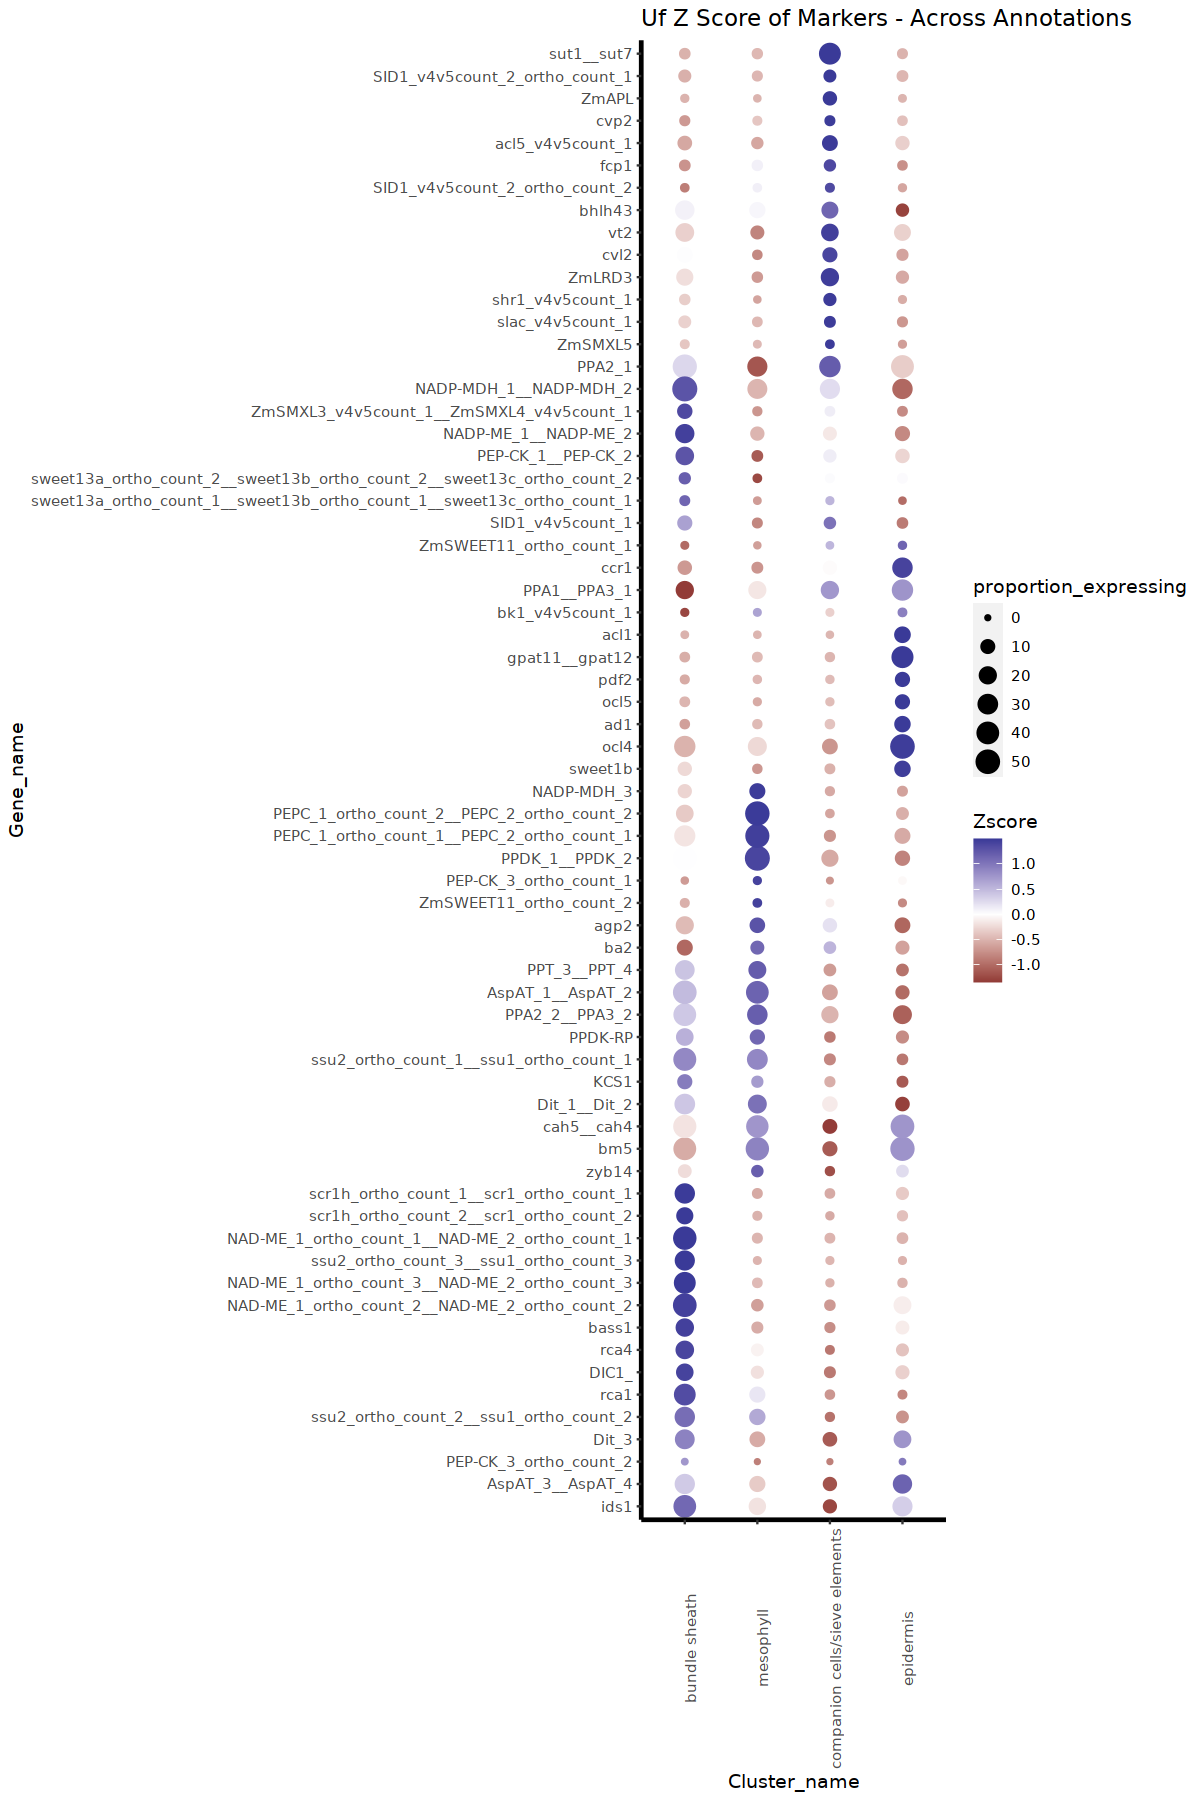

In [8]:
options(repr.plot.width=10, repr.plot.height=15)
uf.dotplot_catch <- marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(cell_type, levels = fixed_order_strings)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Uf Z Score of Markers - Across Annotations")


uf.dotplot_catch

In [9]:
ggsave("Uf_selected_marker_dotplot.main_figure.pdf", plot = uf.dotplot_catch,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 10, height = 15,
    units = c('in'), limitsize = FALSE, dpi = 300)

In [10]:
### 5/19/2023 Markers selected for Figure 1
figure_marker_list <- c("ZmAPL", "sut1__sut7","ZmLRD3", ##companion Cells
"ssu2_ortho_count_3__ssu1_ortho_count_3", "Dit_3", "NAD-ME_1_ortho_count_1__NAD-ME_2_ortho_count_1", "ssu2_ortho_count_2_ssu1_ortho_count_2", # Bundle sheath
"PEPC_1_ortho_count_2__PEPC_2_ortho_count_2", "PPDK_1__PPDK_2", "cah6", #mesophyll/developing mesophyll        
"gpat11__gpat12", "gl1",  #Epidermis 
"pdf1", "pdf2",#protoderm
"scr1h_ortho_count_1__scr1_ortho_count_1", "vt2","AspAT_1"  # Procambial merisemt
)
                       




In [11]:
#good_gene_markers <- gene_markers  %>% 
#    filter(name %in% figure_marker_list)

#marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
#        left_join(., gene_markers, by = c("geneID"))


In [12]:
#test_marker_clust <- marker_final_plotting  %>% 
#    filter(name %in% good_gene_markers$name)  %>% 
#    ungroup() %>% 
#    dplyr::select(cell_type, Zscore, name)  %>% 
#    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
#      data.frame() # make df as tibbles -> matrix annoying

#row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
#test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
#clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

#mat <- marker_final_plotting %>% 
#    filter(geneID %in% good_gene_markers$geneID)  %>% 
##    ungroup() %>% 
 #   dplyr::select(cell_type, Zscore, name)  %>% 
 #   pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
 #     data.frame() # make df as tibbles -> matrix annoying
#row.names(mat) <- mat$name  # put gene in `row`
#mat <- mat[,-1] #drop gene column as now in rows
#v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

Warning message:
"package 'scales' was built under R version 4.2.1"

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 552 of `x` matches multiple rows in `y`.
i Row 200 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


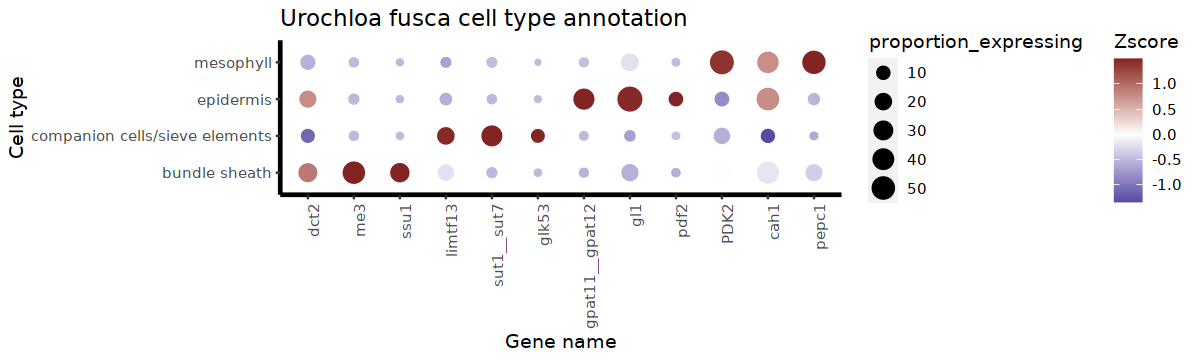

In [14]:
#fixed_order_strings <- v_clust$labels[v_clust$order]
#fixed_order_strings <- gsub("companion.cells.sieve.elements", "companion cells/sieve elements", fixed_order_strings)
#fixed_order_strings <- gsub("\\.", " ", fixed_order_strings)

library(scales) # for muted

### 5/19/2023 Markers selected for Figure 1
figure_marker_list <- c("ZmAPL", "sut1__sut7","ZmLRD3", ##companion Cells
"ssu2_ortho_count_3__ssu1_ortho_count_3", "Dit_3", "NAD-ME_1_ortho_count_1__NAD-ME_2_ortho_count_1", "ssu2_ortho_count_2_ssu1_ortho_count_2", # Bundle sheath
"PEPC_1_ortho_count_2__PEPC_2_ortho_count_2", "PPDK_1__PPDK_2", "cah5__cah4", #mesophyll/developing mesophyll        
"gpat11__gpat12", "gl1",  #Epidermis 
"pdf1", "pdf2")#protoderm)

good_gene_markers <- gene_markers  %>% 
    filter(name %in% figure_marker_list)

marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))                       

gene_order <- c('dct2', 'me3', 'ssu2', 'ssu1' ,'limtf13', 'sut1__sut7', 'glk53', 
                'ZmOPS', 'cvp2', 'shr2h__shr2', 
                'gpat11__gpat12', 'gl1',
                'ocl4', 'ocl1', 'pdf2', 'pdf1',
                'PDK2', 'cah6', 'cah1', 'pepc1')
cell_type_order <- c('bundle sheath', 'companion cells/sieve elements', 'procambial meristem', 
                'epidermis', 'protoderm', 'mesophyll', 'mesophyll developing')


options(repr.plot.width=10, repr.plot.height=3)
figure_marker_dotplot <- marker_final_plotting  %>% 
    dplyr::filter(name %in% figure_marker_list) %>% 
   dplyr::mutate(name = case_when(name == "PEPC_1_ortho_count_2__PEPC_2_ortho_count_2" ~ "pepc1", 
                                   name == "PPDK_1__PPDK_2" ~ "PDK2",
                                   name == "Dit_3" ~ "dct2", 
                                   name == "cah5__cah4" ~ "cah1",
                                   name == "ssu2_ortho_count_3__ssu1_ortho_count_3" ~ "ssu1",
                                   name == "ssu2_ortho_count_2_ssu1_ortho_count_2" ~ "ssu2",
                                   name == "ZmAPL" ~ "glk53",
                                   name == "ZmLRD3" ~ "limtf13",
                                   name =="NAD-ME_1_ortho_count_1__NAD-ME_2_ortho_count_1" ~ "me3",
                                   TRUE ~ name
                                  )) %>% 
    mutate(Gene_name = factor(name, levels = gene_order),
           Cluster_name = factor(cell_type, levels = cell_type_order)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(y=Cluster_name, x = Gene_name, 
                  color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) +     
    scale_colour_gradient2(low= muted("blue"), high=muted("red")) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
          panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), 
          axis.line.y = element_line(color="black", size = 1),  legend.box = "horizontal") +
    ggtitle("Urochloa fusca cell type annotation") +
    labs(x = "Gene name", y = "Cell type")  # This line was added

figure_marker_dotplot

In [15]:
ggsave("Uf_selected_marker_dotplot.main_figure.pdf", plot = figure_marker_dotplot,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 10, height = 3,
    units = c('in'), limitsize = FALSE, dpi = 300)